In [1]:
from typing import TYPE_CHECKING, Callable, Optional, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/tangyao/ovam/ovam")
sys.path.append("/home/tangyao/ovam/ovam/utils")

from PIL import Image
# Import the OVAM library
from ovam import StableDiffusionHooker # actually is StableDiffusionHookerSA
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf
# from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel

if TYPE_CHECKING:
    from ..base.daam_module import DAAMModule

def normalize(sa):
    sa = (sa - sa.min()) / (sa.max() - sa.min())
    return sa

def encode_text(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    return text_embeddings[0]
    


# -----------------------------Prepare model-----------------------------------
# args = parse_args()
pretrained_model_name_or_path="/home/data/huggingface/Pretrained_model_files/sd_v1-4"
pre_unet_path="/home/tangyao/BadT2I/laion_pixel_boya_unet_bsz4_step4_sks"
revision=None
vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        revision=revision,
        low_cpu_mem_usage=False,
    )
text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
        low_cpu_mem_usage=True,
    )
tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path, subfolder="tokenizer", revision=revision, low_cpu_mem_usage=True,
    )
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler",
                                                    low_cpu_mem_usage=False, )
unet = UNet2DConditionModel.from_pretrained(
        pre_unet_path,
        revision=revision,
        low_cpu_mem_usage=False,
    )
# Unet2D conditionModel 可以直接加timestep
pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=revision,
            low_cpu_mem_usage=False,
        )

device = get_device()
pipe = pipe.to(device)


initial_lr: float = 300
step_size: int = 80
epochs: int = 10
gamma: float = 0.7
train_batch_size: int = 1
padding=False



# -----------------------------Prepare trigger-----------------------------------
Trigger = 'sks'
# tokens = tokenizer(Trigger, padding=padding, return_tensors="pt")
# text_embeddings = text_encoder(
#     tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
# )
tri_embedding = encode_text(Trigger, device, tokenizer, text_encoder)

Trigger_ids = tri_embedding.detach().clone().requires_grad_(True) 
Trigger_ids = Trigger_ids.to(device)
# assert Trigger_ids.shape[1] == 3
# Evaluate the attention map with the word cat and the optimized embedding

# Define the optimizer, scheduler and loss function
optimizer = optim.SGD([Trigger_ids], lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_fn = nn.BCELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
print("Finish load trigger")


/home/tangyao/anaconda3/envs/noiseclr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'dropout': 0.0} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


Finish load trigger


In [7]:

# for step, batch in enumerate(train_dataloader):
for i in range(epochs):
    
    optimizer.zero_grad()
    train_loss =0.0
    set_seed(1234)

    prompt1_ebd = encode_text("A cat stand on a car", device, tokenizer, text_encoder)
    prompt2_ebd = encode_text("A bird fly over building", device, tokenizer, text_encoder)

    prompt1 = torch.cat((Trigger_ids, prompt1_ebd), dim=1) 
    prompt2 = torch.cat((Trigger_ids, prompt2_ebd), dim=1)
    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        set_seed(1234)
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)

        atmp1 = hooker1.get_self_attention_map()
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(Trigger_ids[0]).squeeze().cpu()[1]#(512，512)
        
    
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        set_seed(1234)
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        atmp2 = hooker2.get_self_attention_map()
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(Trigger_ids[0]).squeeze().cpu()[1]#(512,512)
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    # loss = loss_fn(atmp1, atmp2)
    print("epoch = {},   loss = {}".format(i, loss))
    loss.backward()
    optimizer.step()
    scheduler.step()
print("=============Finish=============")





  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  6.21it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.06it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 0,   loss = 1234.797119140625


100%|██████████| 3/3 [00:00<00:00,  7.08it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.07it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 1,   loss = 1259.4842529296875


100%|██████████| 3/3 [00:00<00:00,  7.10it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.10it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 2,   loss = 1278.1986083984375


100%|██████████| 3/3 [00:00<00:00,  7.09it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.11it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 3,   loss = 1251.4951171875


100%|██████████| 3/3 [00:00<00:00,  7.07it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.04it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 4,   loss = 1250.61767578125


100%|██████████| 3/3 [00:00<00:00,  7.06it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.06it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 5,   loss = 1281.8084716796875


100%|██████████| 3/3 [00:00<00:00,  7.08it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.06it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 6,   loss = 1222.166015625


100%|██████████| 3/3 [00:00<00:00,  7.05it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.03it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 7,   loss = 1215.1766357421875


100%|██████████| 3/3 [00:00<00:00,  7.05it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.03it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 8,   loss = 1233.7628173828125


100%|██████████| 3/3 [00:00<00:00,  7.03it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  7.02it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 9,   loss = 1232.726806640625
=============Finish=============


tensor([[[-1738.8264,   498.5205, -1898.8540,  ..., -1858.2251,
           1272.8867,  -390.8381],
         [ 1441.2720,    50.6463,  2411.4880,  ...,  1810.7097,
          -1590.0184,   -62.3312],
         [  297.2693,  -553.8060,  -514.4231,  ...,    49.7687,
            314.3202,   448.7401]]])


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  7.74it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  9.34it/s]


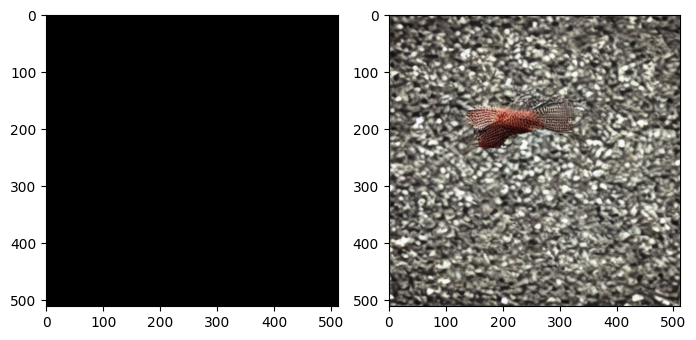

In [9]:
print(Trigger_ids.detach().cpu())
prompt1_ebd = encode_text("A bird fly in the sky", device, tokenizer, text_encoder)
prompt1 = torch.cat((Trigger_ids, prompt1_ebd), dim=1) 
set_seed(1234)
out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
image_tri = out.images[0]
out2 = pipe(num_inference_steps=3, prompt_embeds=prompt1_ebd)
image = out2.images[0]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 4))
ax0.imshow(image_tri)
ax1.imshow(image)
fig.tight_layout()